<a href="https://www.kaggle.com/code/klyushnik/listening-time-13-26764?scriptVersionId=235498560" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e4/sample_submission.csv
/kaggle/input/playground-series-s5e4/train.csv
/kaggle/input/playground-series-s5e4/test.csv


# Description

**My name is Alexander and I present to your attention my vision of the dataset, model selection and results.**

**Your Goal: Your task it to predict listening time of a podcast episode.**

![06-Perfect-length-768x402.png](https://wearesoundmedia.com/wp-content/uploads/2022/02/06-Perfect-length-768x402.png)


## Root Mean Squared Error (RMSE)

Submissions are scored on the root mean squared error. RMSE is defined as:

$$
RMSE = \sqrt{\frac{1}{N} \sum_{i=1}^{N} (y_i - \hat{y}_i)^2}
$$

where \(\hat{y}_i\) is the predicted value and \(y_i\) is the original value for each instance \(i\).

Welcome to my github - https://github.com/Alexsandrrus

# Imports

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib
from matplotlib.pyplot import figure

import numpy as np
import pandas as pd
from scipy import stats
from scipy.optimize import minimize
from scipy.stats import mstats
from scipy.stats.mstats import winsorize

from sklearn import preprocessing
from sklearn.preprocessing import (
    LabelEncoder,
    QuantileTransformer,
    StandardScaler,
    PowerTransformer,
    MaxAbsScaler,
    MinMaxScaler,
    RobustScaler,
    PolynomialFeatures,
    OrdinalEncoder,
    OneHotEncoder,
    FunctionTransformer,
    KBinsDiscretizer,
)
from sklearn.feature_selection import (
    VarianceThreshold,
    SelectKBest,
    f_regression,
    SequentialFeatureSelector,
)
from sklearn.model_selection import (
    StratifiedKFold,
    KFold,
    StratifiedGroupKFold,
    RepeatedStratifiedKFold,
    RepeatedKFold,
    cross_validate,
    train_test_split,
    TimeSeriesSplit,
)
from sklearn.linear_model import (
    SGDOneClassSVM,
    LinearRegression,
    Ridge,
    Lasso,
    ElasticNet,
)
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import (
    HistGradientBoostingRegressor,
    ExtraTreesRegressor,
    GradientBoostingRegressor,
    IsolationForest,
    BaggingRegressor,
    RandomForestRegressor,
)
from sklearn.decomposition import PCA
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error, 
    r2_score
)
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

import tensorflow as tf
from tensorflow.keras.models import clone_model
import keras
from keras_tuner import RandomSearch, BayesianOptimization
from keras import layers
from keras.layers import (
    BatchNormalization,
    Flatten,
    Dense,
    Dropout,
    Activation,
)
from tensorflow.keras.models import Sequential
from keras import backend as K
import keras_tuner
from keras_tuner import Hyperband
from functools import partial

import optuna
from optuna.samplers import CmaEsSampler
from optuna.pruners import MedianPruner
import optuna.visualization as vis

from catboost import CatBoostRegressor
import xgboost as xgb
from lightgbm import LGBMRegressor
from mlxtend.regressor import StackingRegressor, StackingCVRegressor
from category_encoders import TargetEncoder, MEstimateEncoder
#from cuml.preprocessing import TargetEncoder

import requests
import holidays
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing

import warnings
import re
import time
import logging
from functools import partial
from itertools import combinations
from IPython.display import Image

from functools import partial

# Visualization settings
plt.style.use('ggplot')
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12, 8)
sns.set_context("notebook", font_scale=1.2)
sns.set_style("whitegrid")

# Pandas settings
pd.options.mode.chained_assignment = None

# Logging configuration
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Warnings configuration
warnings.filterwarnings('ignore')

# My setting

In [3]:
def plot_numerical_features(df):
    num_features = df.select_dtypes(include=[np.number]).columns
    ncols = 2
    nrows = (len(num_features) + ncols - 1) // ncols

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 6 * nrows))
    axes = axes.flatten()

    for i, feature in enumerate(num_features):
        sns.histplot(df[feature], bins=30, kde=True, ax=axes[i], color='skyblue', edgecolor='black')
        axes[i].set_title(f'Distribution of {feature}', fontsize=18, fontweight='bold')
        axes[i].set_xlabel(feature, fontsize=14)
        axes[i].set_ylabel('Frequency', fontsize=14)
        axes[i].grid(True, linestyle='--', alpha=0.7)  

        mean_value = df[feature].mean()
        axes[i].axvline(mean_value, color='red', linestyle='--', label='Mean')
        axes[i].legend()

    plt.tight_layout()
    plt.show()

def plot_numerical_boxplots(df):
    num_features = df.select_dtypes(include=[np.number]).columns
    ncols = 2
    nrows = (len(num_features) + ncols - 1) // ncols

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 6 * nrows))
    axes = axes.flatten()

    for i, feature in enumerate(num_features):
        sns.boxplot(x=df[feature], ax=axes[i], color='lightgreen')
        axes[i].set_title(f'Boxplot of {feature}', fontsize=18, fontweight='bold')
        axes[i].set_xlabel(feature, fontsize=14)
        axes[i].grid(True, linestyle='--', alpha=0.7)  

        median_value = df[feature].median()
        axes[i].axvline(median_value, color='orange', linestyle='--', label='Median')
        axes[i].legend()

    plt.tight_layout()
    plt.show()

def plot_qq_plot(df):
    num_features = df.select_dtypes(include=[np.number]).columns
    ncols = 2
    nrows = (len(num_features) + ncols - 1) // ncols

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 6 * nrows))
    axes = axes.flatten()

    for i, feature in enumerate(num_features):
        stats.probplot(df[feature], dist="norm", plot=axes[i])
        axes[i].set_title(f'QQ Plot of {feature}', fontsize=18, fontweight='bold')
        axes[i].set_xlabel('Theoretical Quantiles', fontsize=14)
        axes[i].set_ylabel('Sample Quantiles', fontsize=14)
        axes[i].grid(True, linestyle='--', alpha= 0.7)  

    plt.tight_layout()
    plt.show()

def plot_correlation_matrix(df, method='spearman'):
    num_df = df.select_dtypes(include=[np.number])
    
    corr = num_df.corr(method=method)
    plt.figure(figsize=(14, 10))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8}, linewidths=.5)
    plt.title(f'Correlation Matrix ({method.capitalize()} Correlation)', fontsize=18, fontweight='bold')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()

def plot_pairplot(df):
    num_features = df.select_dtypes(include=[np.number]).columns
    sns.pairplot(df[num_features], diag_kind='kde', plot_kws={'alpha': 0.6, 'edgecolor': 'k'}, height=2.5)
    plt.suptitle('Pairplot of Numerical Features', y=1.02, fontsize=18, fontweight='bold')
    plt.show()

def plot_categorical_features(df, ncols=2, top_n=None):
    cat_features = df.select_dtypes(include=[object]).columns
    nrows = (len(cat_features) + ncols - 1) // ncols

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 6 * nrows))
    axes = axes.flatten()

    for i, feature in enumerate(cat_features):
        if top_n is not None:
            top_categories = df[feature].value_counts().nlargest(top_n).index
            sns.countplot(data=df[df[feature].isin(top_categories)], y=feature, ax=axes[i], palette='viridis', order=top_categories)
        else:
            sns.countplot(data=df, y=feature, ax=axes[i], palette='viridis')
        
        axes[i].set_title(f'Count of {feature}', fontsize=18, fontweight='bold')
        axes[i].set_xlabel('Count', fontsize=14)
        axes[i].set_ylabel(feature, fontsize=14)
        axes[i].tick_params(axis='y', rotation=0)
        axes[i].grid(True, linestyle='--', alpha=0.7)  
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

def PolynomialFeatures_labeled(input_df,power):
   
    poly = preprocessing.PolynomialFeatures(power)
    output_nparray = poly.fit_transform(input_df)
    powers_nparray = poly.powers_

    input_feature_names = list(input_df.columns)
    target_feature_names = ["Constant Term"]
    for feature_distillation in powers_nparray[1:]:
        intermediary_label = ""
        final_label = ""
        for i in range(len(input_feature_names)):
            if feature_distillation[i] == 0:
                continue
            else:
                variable = input_feature_names[i]
                power = feature_distillation[i]
                intermediary_label = "%s+%d" % (variable,power)
                if final_label == "":         #If the final label isn't yet specified
                    final_label = intermediary_label
                else:
                    final_label = final_label + "x" + intermediary_label
        target_feature_names.append(final_label)
    output_df = pd.DataFrame(output_nparray, columns = target_feature_names)
    return output_df

def variance_threshold(df,th):
    var_thres=VarianceThreshold(threshold=th)
    var_thres.fit(df)
    new_cols = var_thres.get_support()
    return df.iloc[:,new_cols]
   
def optimize_memory_usage(df, print_size=True):
    """
    Optimizes memory usage in a DataFrame by downcasting numeric columns.

    Parameters:
        df (pd.DataFrame): The DataFrame to optimize.
        print_size (bool): If True, prints memory usage before and after optimization.

    Returns:
        pd.DataFrame: The optimized DataFrame.
    """
    # Types for optimization.
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    
    # Memory usage size before optimize (Mb).
    before_size = df.memory_usage().sum() / 1024**2
    
    for column in df.columns:
        column_type = df[column].dtype
        
        if column_type in numerics:
            try:
                if str(column_type).startswith('int'):
                    df[column] = pd.to_numeric(df[column], downcast='integer')
                else:
                    df[column] = pd.to_numeric(df[column], downcast='float')
                logger.info(f"Optimized column {column}: {column_type} -> {df[column].dtype}")
            except Exception as e:
                logger.error(f"Failed to optimize column {column}: {e}")
    
    # Memory usage size after optimize (Mb).
    after_size = df.memory_usage().sum() / 1024**2
    
    if print_size:
        print(
            'Memory usage size: before {:5.4f} Mb - after {:5.4f} Mb ({:.1f}%).'.format(
                before_size, after_size, 100 * (before_size - after_size) / before_size
            )
        )
    
    return df

# Data

## Load

In [4]:
train = pd.read_csv('/kaggle/input/playground-series-s5e4/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s5e4/test.csv')

train.shape, test.shape

((750000, 12), (250000, 11))

## Info

In [5]:
test = test.drop(['id'], axis =1)
train = train.drop(['id'], axis =1)

train.shape, test.shape

((750000, 11), (250000, 10))

In [6]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
Episode_Length_minutes,662907.0,64.504738,32.969603,0.0,35.73000,63.84000,94.07000,325.24
Host_Popularity_percentage,750000.0,59.859901,22.873098,1.3,39.41000,60.05000,79.53000,119.46
Guest_Popularity_percentage,603970.0,52.236449,28.451241,0.0,28.38000,53.58000,76.60000,119.91
Number_of_Ads,749999.0,1.348855,1.151130,0.0,0.00000,1.00000,2.00000,103.91
Listening_Time_minutes,750000.0,45.437406,27.138306,0.0,23.17835,43.37946,64.81158,119.97


In [7]:
duplicates = train.duplicated()
print(f"Number of duplicates: {duplicates.sum()}")

train = train.drop_duplicates()

Number of duplicates: 0


In [8]:
for col in train.columns:
    pct_missing = np.mean(train[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

Podcast_Name - 0%
Episode_Title - 0%
Episode_Length_minutes - 12%
Genre - 0%
Host_Popularity_percentage - 0%
Publication_Day - 0%
Publication_Time - 0%
Guest_Popularity_percentage - 19%
Number_of_Ads - 0%
Episode_Sentiment - 0%
Listening_Time_minutes - 0%


In [9]:
for col in test.columns:
    pct_missing = np.mean(test[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

Podcast_Name - 0%
Episode_Title - 0%
Episode_Length_minutes - 11%
Genre - 0%
Host_Popularity_percentage - 0%
Publication_Day - 0%
Publication_Time - 0%
Guest_Popularity_percentage - 20%
Number_of_Ads - 0%
Episode_Sentiment - 0%


## Optimize memory

In [10]:
train = optimize_memory_usage(train)
test = optimize_memory_usage(test)

Memory usage size: before 62.9426 Mb - after 48.6375 Mb (22.7%).
Memory usage size: before 19.0736 Mb - after 15.2589 Mb (20.0%).


# EDA

## Numerical features

### Hist  

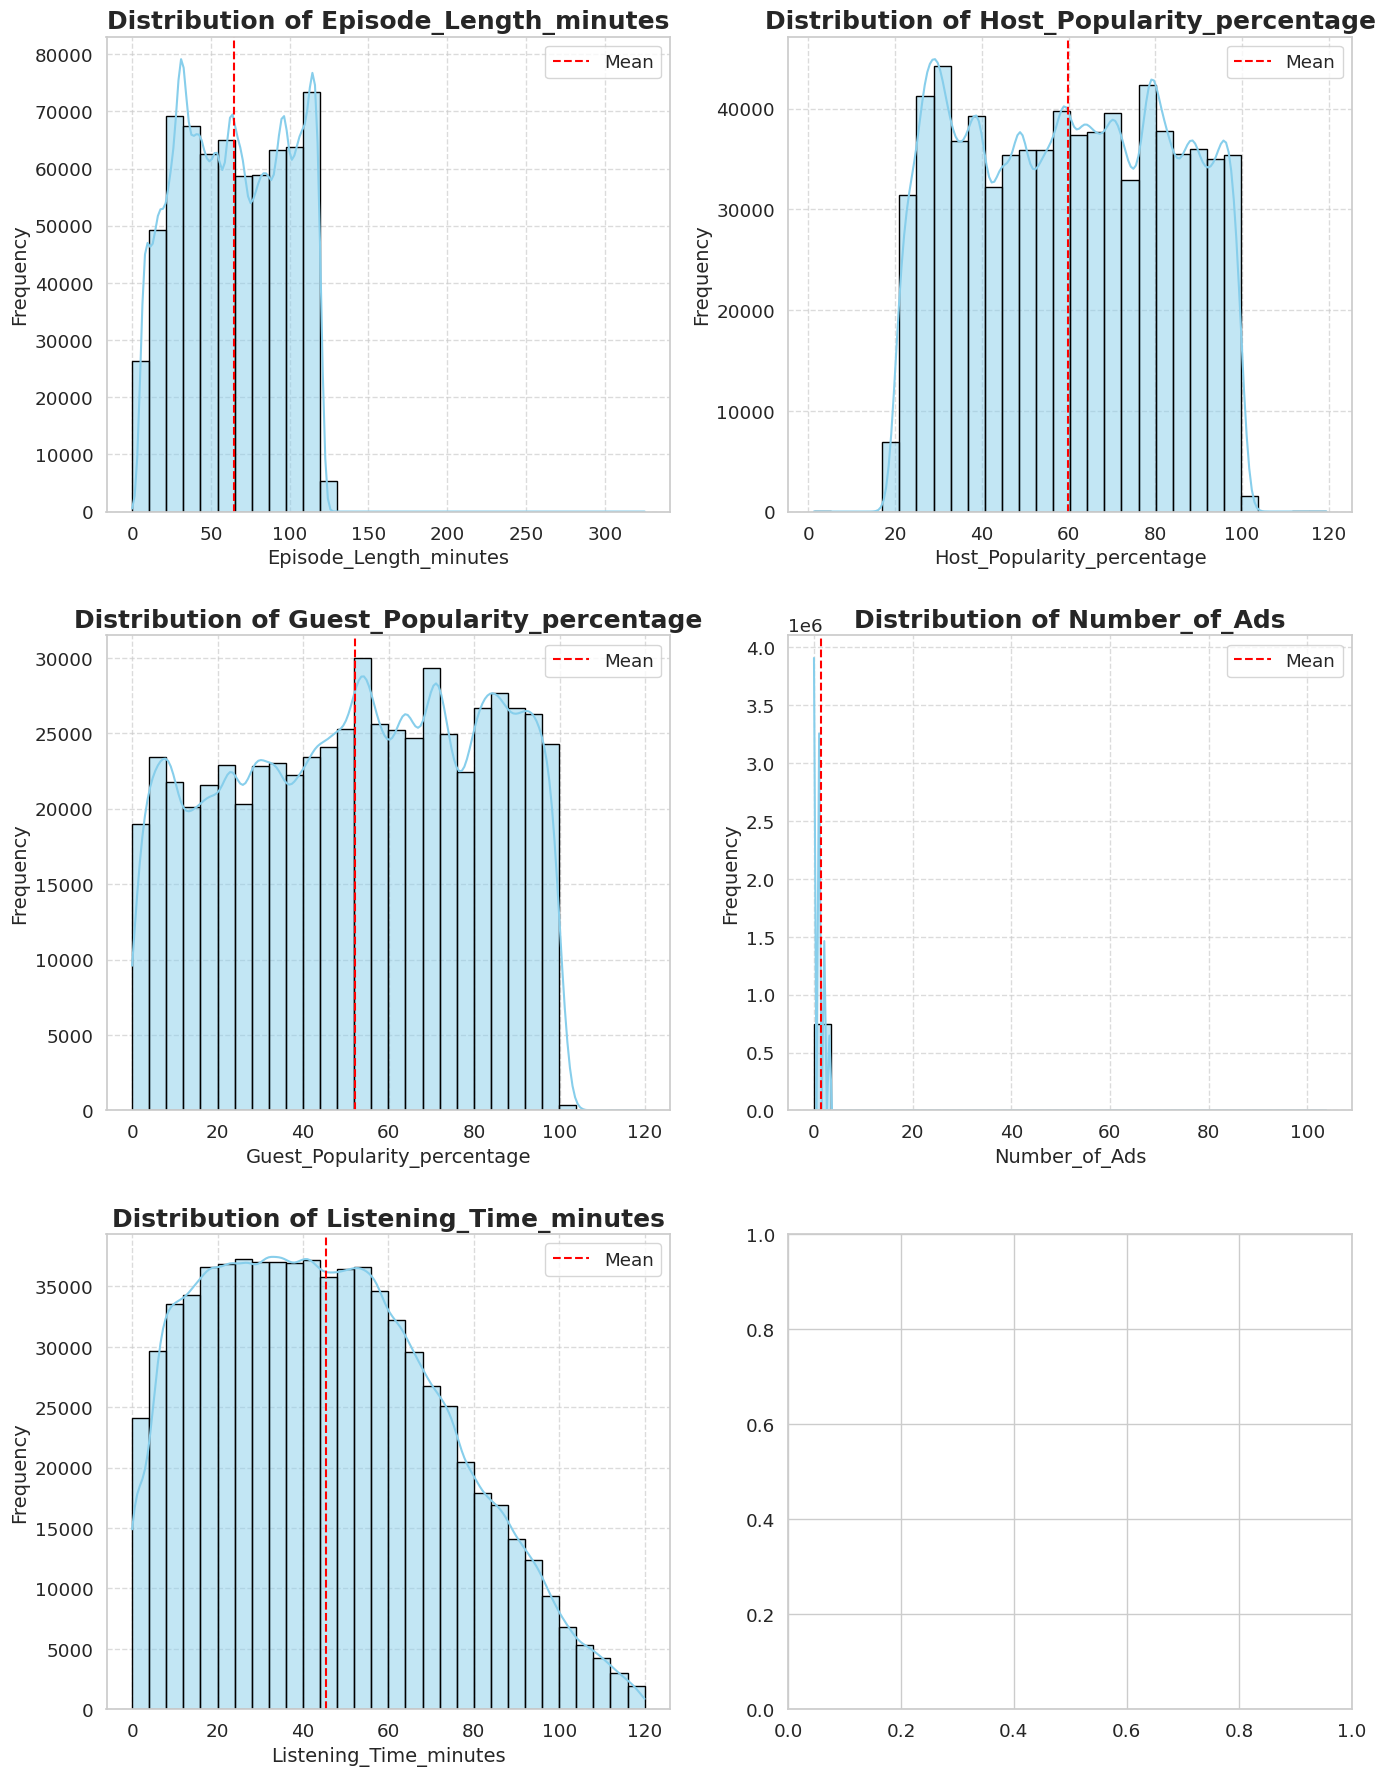

In [11]:
plot_numerical_features(train)

### Box

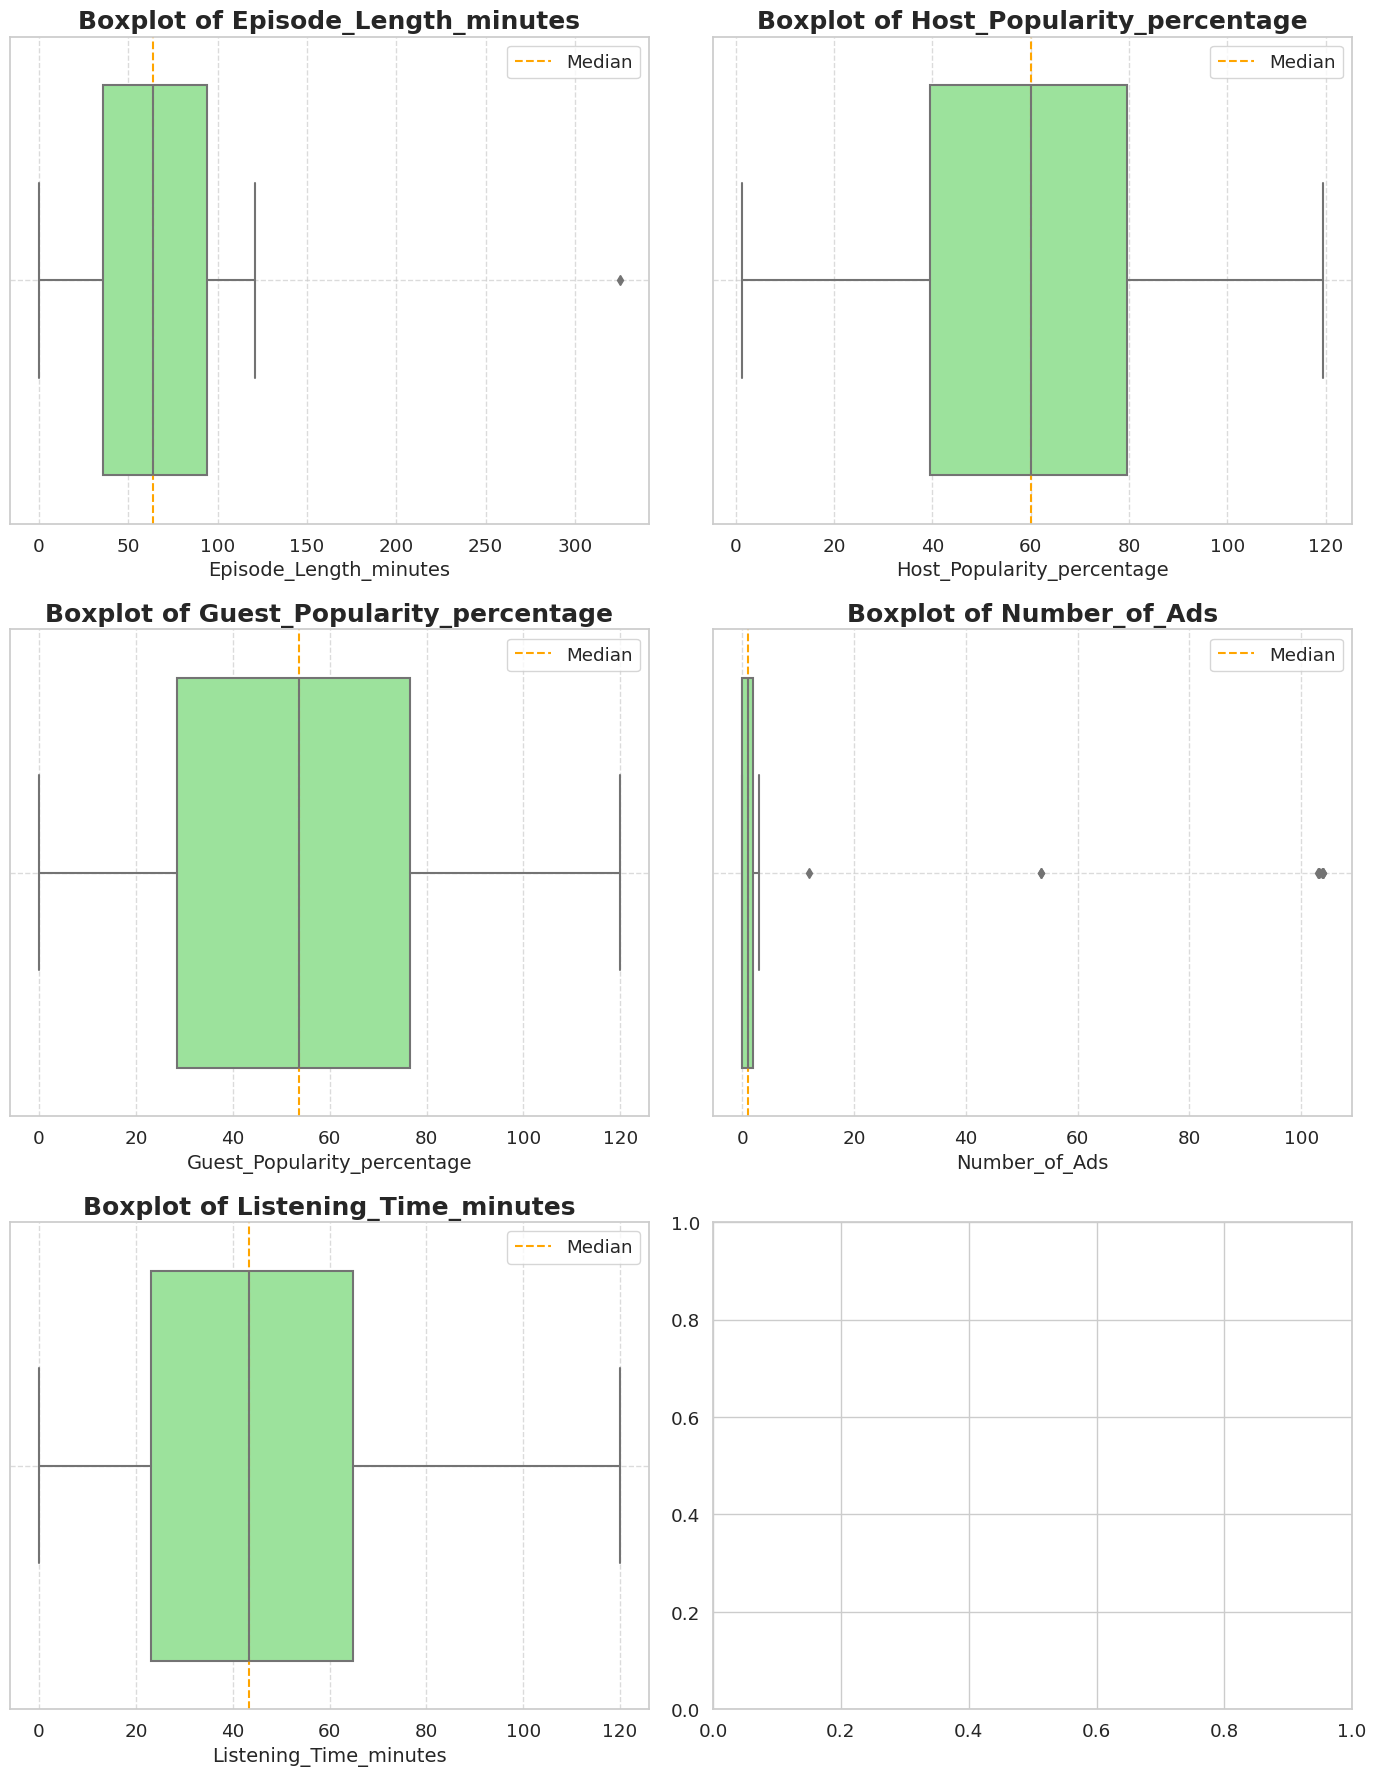

In [12]:
plot_numerical_boxplots(train)

### Q-Q

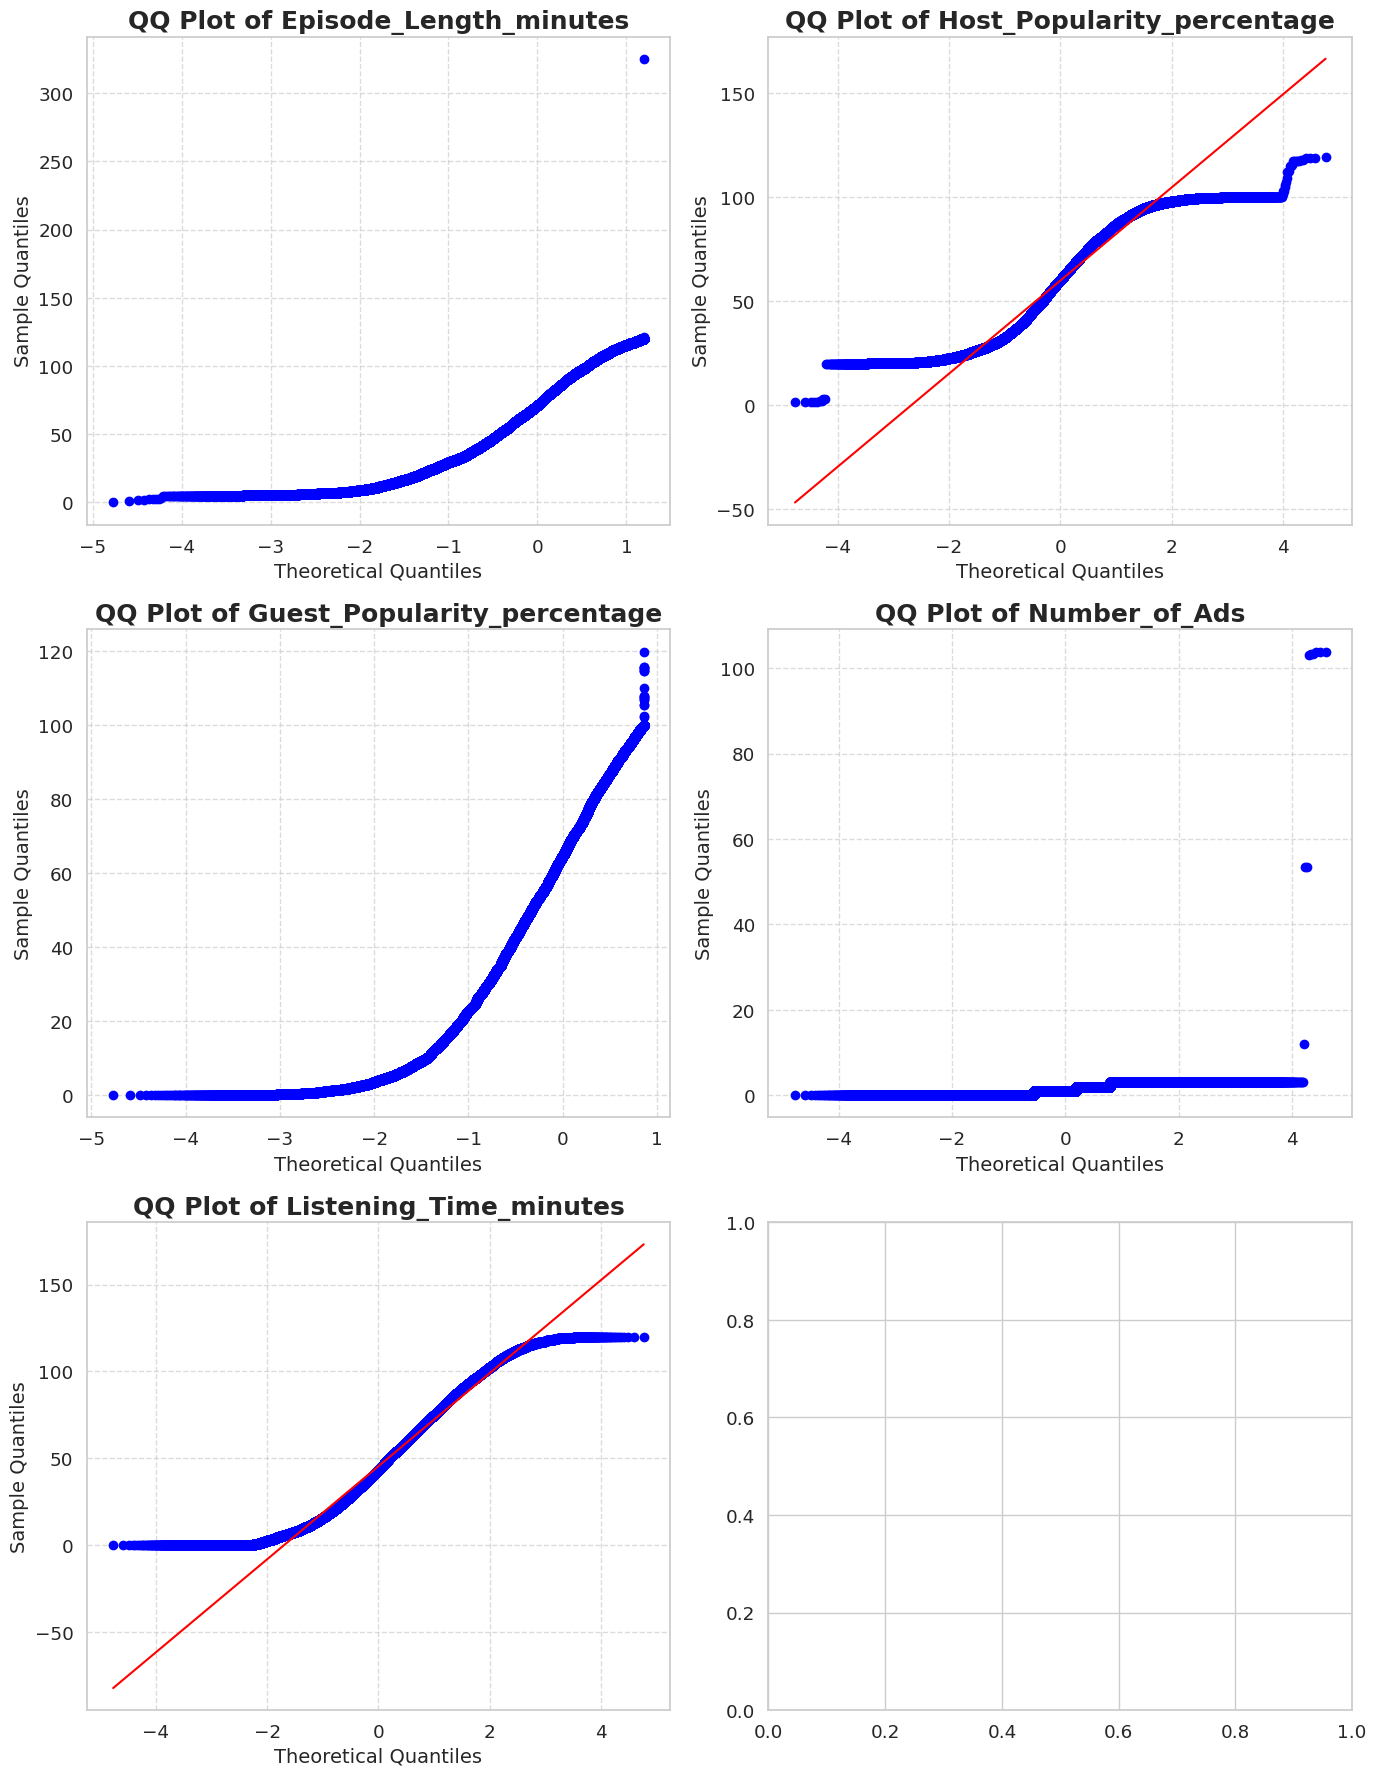

In [13]:
plot_qq_plot(train)

## Correlation matrix

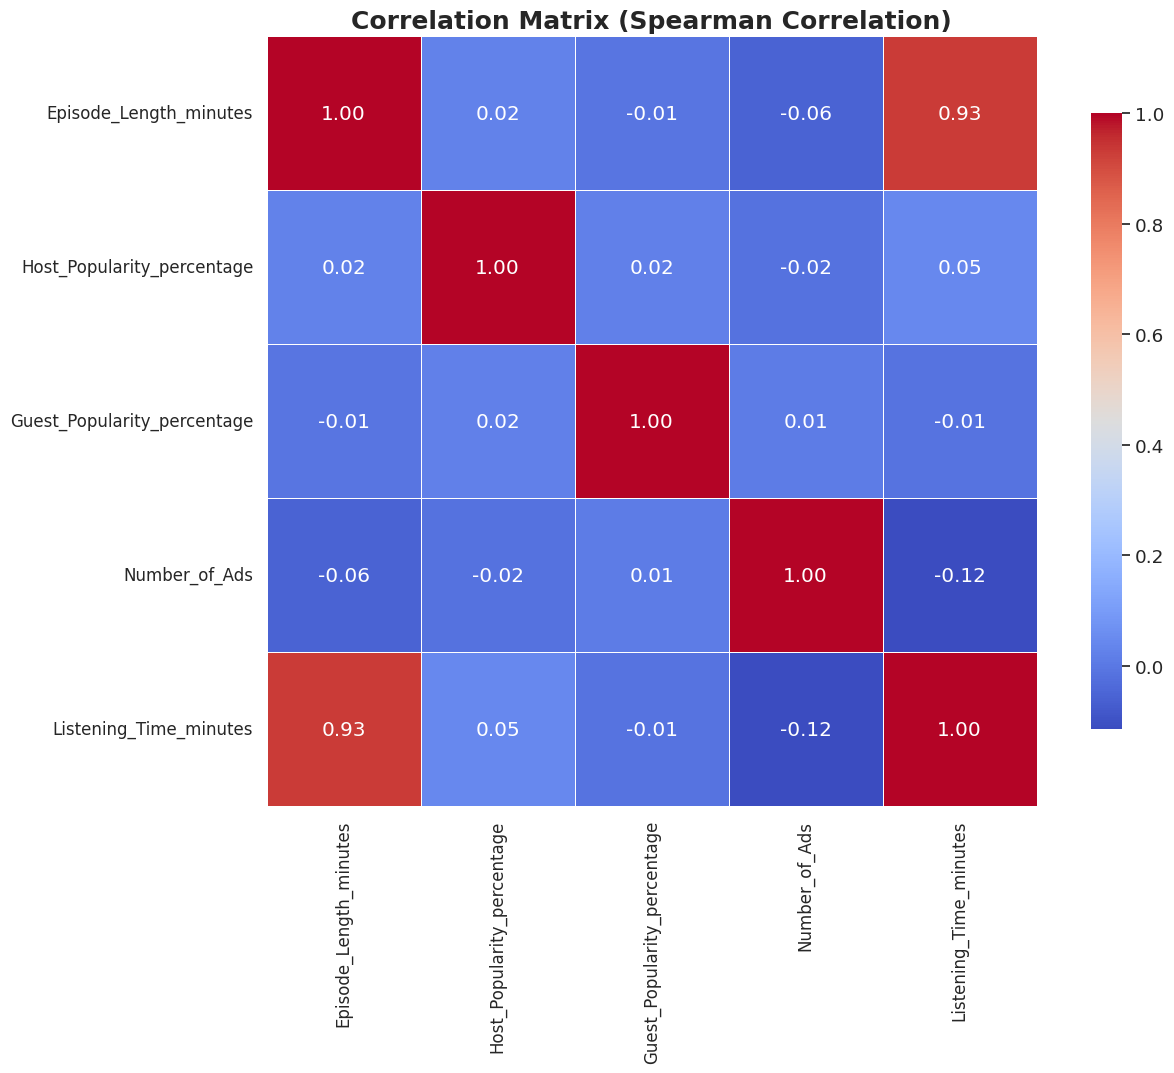

In [14]:
plot_correlation_matrix(train)

## Categorical features

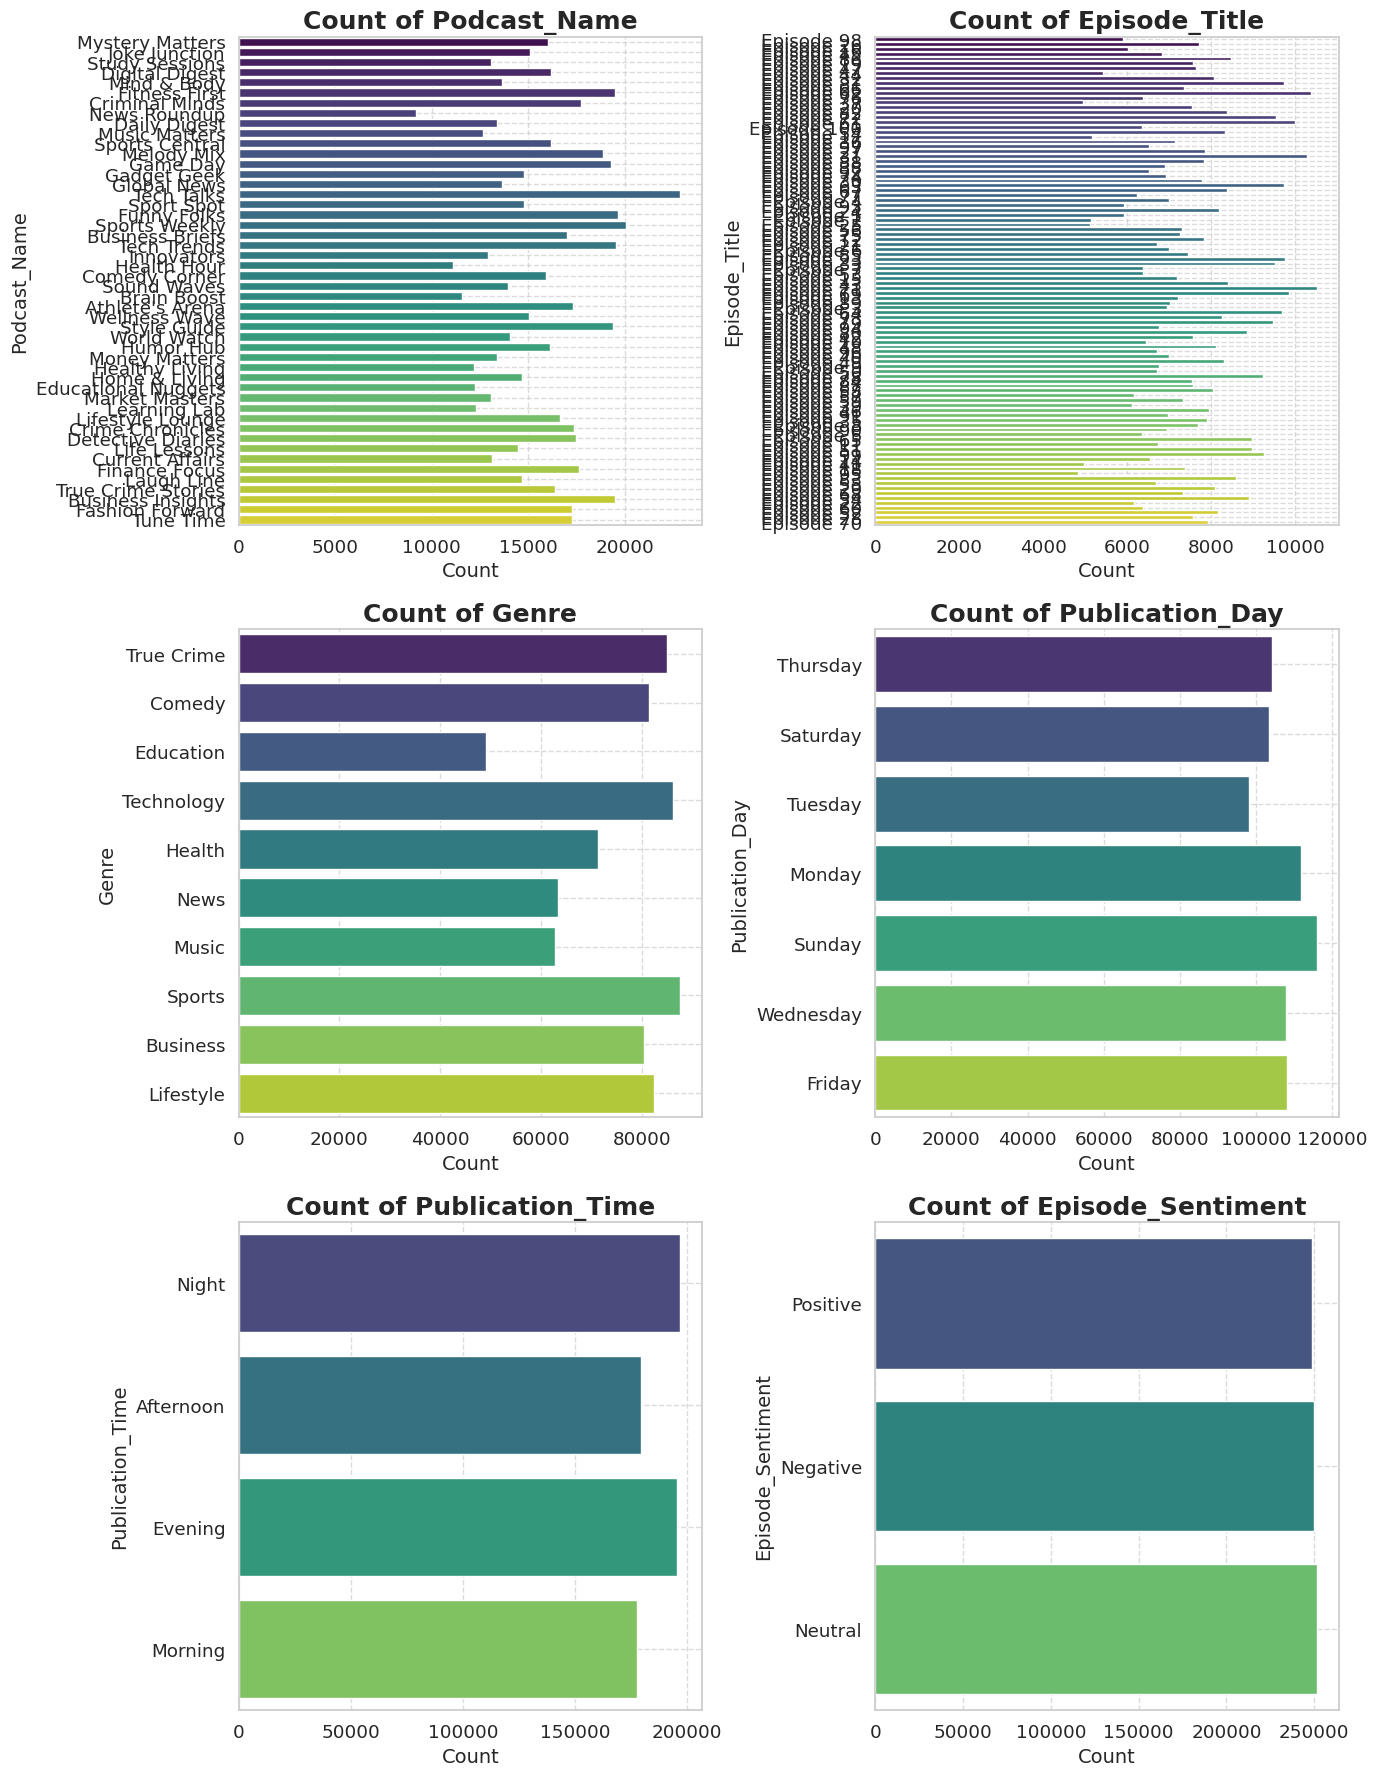

In [15]:
plot_categorical_features(train)

## Some notice

<Figure size 1600x1000 with 0 Axes>

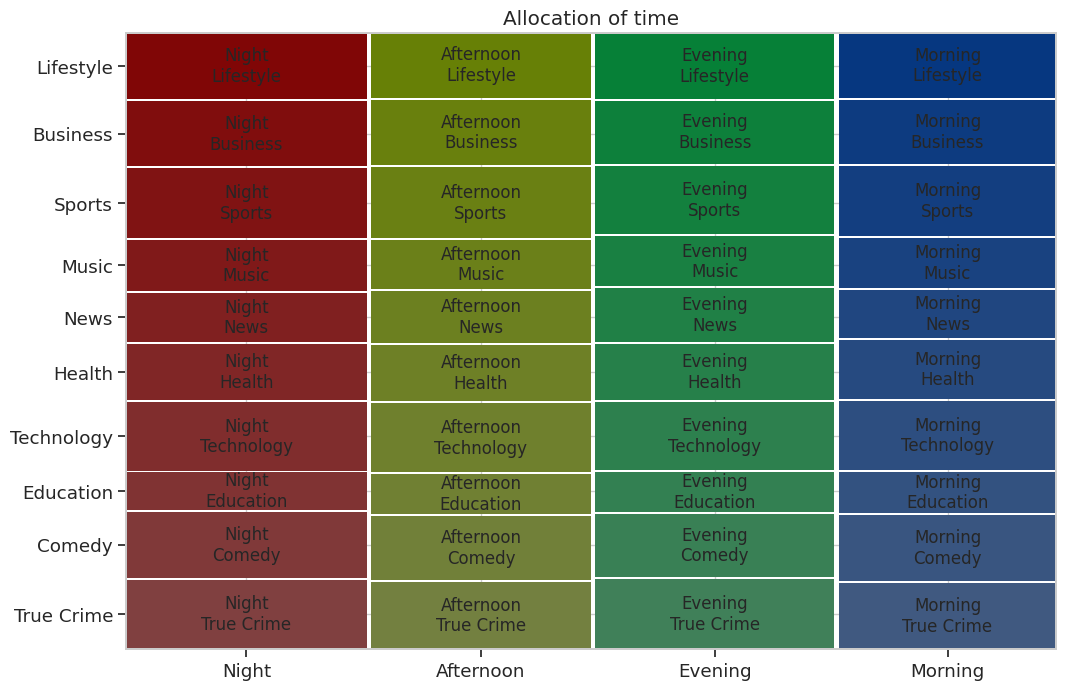

In [16]:
from statsmodels.graphics.mosaicplot import mosaic

plt.figure(figsize=(16, 10))
mosaic(train, ['Publication_Time', 'Genre'], title='Allocation of time')
plt.show()

<Figure size 1600x1000 with 0 Axes>

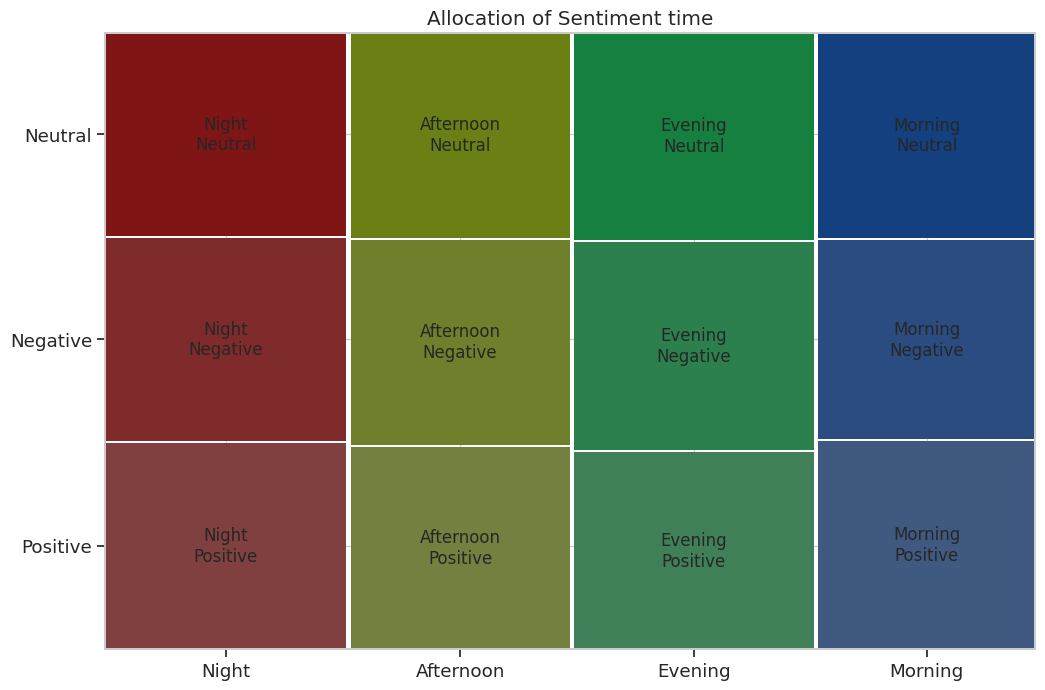

In [17]:
plt.figure(figsize=(16, 10))
mosaic(train, ['Publication_Time', 'Episode_Sentiment'], title='Allocation of Sentiment time')
plt.show()

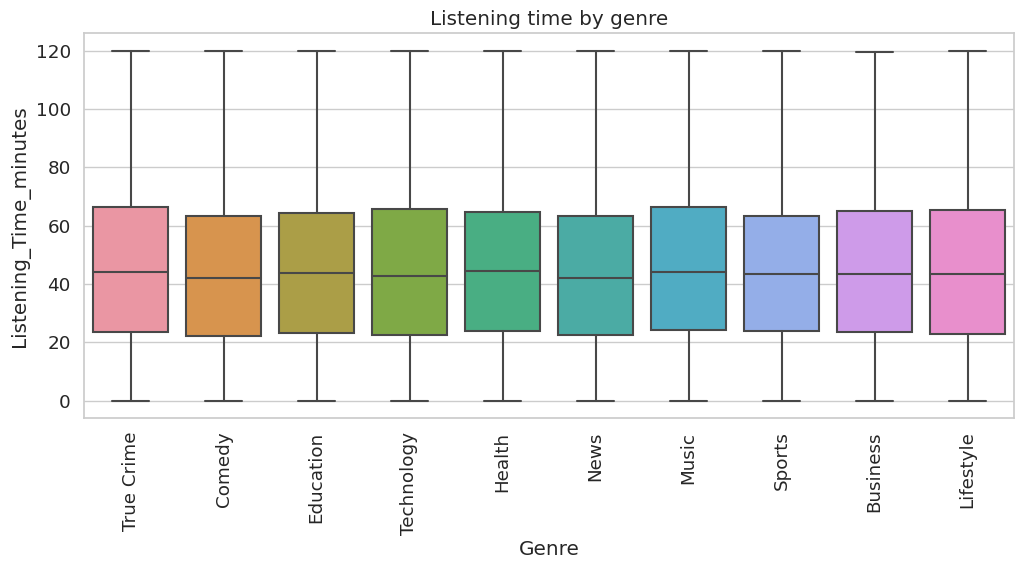

In [18]:
plt.figure(figsize=(12, 5))
sns.boxplot(x='Genre', y='Listening_Time_minutes', data=train)
plt.xticks(rotation=90)
plt.title('Listening time by genre')
plt.show()

# New features

In [19]:
train['Episode_Length_minutes'] = train['Episode_Length_minutes'].fillna(train['Episode_Length_minutes'].median())
train['Guest_Popularity_percentage'] = train['Guest_Popularity_percentage'].fillna(train['Guest_Popularity_percentage'].median())
train['Number_of_Ads'] = train['Number_of_Ads'].fillna(train['Number_of_Ads'].median())

test['Episode_Length_minutes'] = test['Episode_Length_minutes'].fillna(test['Episode_Length_minutes'].median())
test['Guest_Popularity_percentage'] = test['Guest_Popularity_percentage'].fillna(test['Guest_Popularity_percentage'].median())
test['Number_of_Ads'] = test['Number_of_Ads'].fillna(test['Number_of_Ads'].median())

In [20]:
# for col in train.select_dtypes(include=['number']).columns:
#     train[col] = winsorize(train[col], limits=[0.05, 0.05])
Q1 = train['Number_of_Ads'].quantile(0.25)
Q3 = train['Number_of_Ads'].quantile(0.75)
IQR = Q3 - Q1

lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

train = train[
    (train['Number_of_Ads'] >= lower) &
    (train['Number_of_Ads'] <= upper)
]

train.shape, test.shape

((749991, 11), (250000, 10))

In [21]:
def categorize_variable(df, column, labels):
    
    if len(labels) != 3:
        raise ValueError("3 type")
    
    bins = [-float('inf'), 
            df[column].quantile(0.25), 
            df[column].quantile(0.75), 
            float('inf')]
    
    df[f'{column}_group'] = pd.cut(df[column], bins=bins, labels=labels)
    return df

In [22]:
categorize_variable(train, 'Episode_Length_minutes', ["short", "mean", 'long'])
categorize_variable(train, 'Host_Popularity_percentage', ["low", "normal", 'high'])
categorize_variable(train, 'Guest_Popularity_percentage', ["low_important", "mean", 'top'])

categorize_variable(test, 'Episode_Length_minutes', ["short", "mean", 'long'])
categorize_variable(test, 'Host_Popularity_percentage', ["low", "normal", 'high'])
categorize_variable(test, 'Guest_Popularity_percentage', ["low_important", "mean", 'top'])

train.shape, test.shape

((749991, 14), (250000, 13))

# X,y make transform

## Target Encode

In [23]:
col = ['Podcast_Name', 'Episode_Title', 'Genre', 'Publication_Day',
       'Publication_Time', 'Episode_Sentiment', 'Episode_Length_minutes_group',
      'Host_Popularity_percentage_group','Guest_Popularity_percentage_group']
col_num = ['Episode_Length_minutes', 'Host_Popularity_percentage',
       'Guest_Popularity_percentage', 'Number_of_Ads']

TE = MEstimateEncoder(cols=col, m=5.0)


train[col] = TE.fit_transform(train[col], train['Listening_Time_minutes'])
test[col] = TE.transform(test[col])

train.shape, test.shape

((749991, 14), (250000, 13))

In [24]:
X = train.drop(columns=['Listening_Time_minutes'])
y = train['Listening_Time_minutes']
print('before threshold:',X.shape, y.shape)

X = variance_threshold(X,0.03)
list_name = (X.columns)
test = test[list_name]

print('after threshold:',X.shape, y.shape)

before threshold: (749991, 13) (749991,)
after threshold: (749991, 13) (749991,)


In [25]:
scaler = StandardScaler()

X[X.select_dtypes(include=[np.number]).columns] = scaler.fit_transform(X[X.select_dtypes(include=[np.number]).columns])
test[X.select_dtypes(include=[np.number]).columns] = scaler.transform(test[X.select_dtypes(include=[np.number]).columns])

X.shape, y.shape, test.shape

((749991, 13), (749991,), (250000, 13))

# Model

## Keras

In [26]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError:
    tpu = None
    gpus = tf.config.experimental.list_logical_devices("GPU")
    
if tpu:
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu,) 
    print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
elif len(gpus) > 1:
    strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
    print('Running on multiple GPUs ', [gpu.name for gpu in gpus])
elif len(gpus) == 1:
    strategy = tf.distribute.get_strategy() 
    print('Running on single GPU ', gpus[0].name)
else:
    strategy = tf.distribute.get_strategy() 
    print('Running on CPU')
print("Number of accelerators: ", strategy.num_replicas_in_sync)

Running on CPU
Number of accelerators:  1


# Train model and pedict

In [ ]:
def build_deep_lstm_model(input_shape):
    model = keras.Sequential()
    
    model.add(layers.InputLayer(input_shape=input_shape))
    
    model.add(layers.Conv1D(128, 5, activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling1D(2))
    model.add(layers.Dropout(0.3))
    
    model.add(layers.LSTM(128, return_sequences=False, activation='tanh', recurrent_dropout=0.2))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.4))
    
    model.add(layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(1e-3)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    
    model.add(layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(1e-3)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    
    model.add(layers.Dense(1, activation='linear'))
    
    model.compile(optimizer=keras.optimizers.Nadam(1e-4), loss='mse', metrics=['mse', 'mae'])
    return model

folds = 5
models = []
all_predictions = np.zeros(len(X))
fold_scores = []
kf = KFold(n_splits=folds, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    print(f"\n=== Fold {fold+1}/{folds} ===")
    
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    X_train = np.expand_dims(X_train.values, axis=-1) if isinstance(X_train, pd.DataFrame) else np.expand_dims(X_train, axis=-1)
    X_val = np.expand_dims(X_val.values, axis=-1) if isinstance(X_val, pd.DataFrame) else np.expand_dims(X_val, axis=-1)
    
    model = build_deep_lstm_model(input_shape=(X_train.shape[1], 1))
    
    callbacks = [
        keras.callbacks.EarlyStopping(monitor='val_mse', patience=10, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(monitor='val_mse', factor=0.2, patience=5, verbose=1)
    ]
    
    history = model.fit(
        X_train, y_train,
        batch_size=64,
        epochs=30,
        validation_data=(X_val, y_val),
        callbacks=callbacks,
        verbose=1
    )
    
    models.append(model)
    oof_pred = model.predict(X_val).flatten()
    all_predictions[val_idx] = oof_pred
    
    fold_mse = mean_squared_error(y_val, oof_pred)
    fold_scores.append(fold_mse)
    print(f"Fold {fold+1} MSE: {fold_mse:.4f}")
    
    plt.plot(history.history['val_mse'], label=f'Fold {fold+1}')

print("\n=== Cross-Validation Results ===")
print(f"Average MSE: {np.mean(fold_scores):.4f}")
print(f"Std Dev: {np.std(fold_scores):.4f}")

plt.title('Validation MSE across Folds')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

if 'test' in locals():
    test_array = test.values if isinstance(test, pd.DataFrame) else test
    test_array = np.expand_dims(test_array, axis=-1)
    
    test_predictions = np.zeros((len(test_array), folds))
    for i, model in enumerate(models):
        test_predictions[:, i] = model.predict(test_array).flatten()
    
    final_predictions = np.mean(test_predictions, axis=1)


=== Fold 1/5 ===
Epoch 1/20
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 192s 20ms/step - loss: 1647.4628 - mae: 34.7096 - mse: 1647.1193 - val_loss: 203.6007 - val_mae: 10.7548 - val_mse: 203.2537 - learning_rate: 1.0000e-04
Epoch 2/20
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 189s 20ms/step - loss: 271.3421 - mae: 12.5776 - mse: 270.9940 - val_loss: 183.5649 - val_mae: 9.9718 - val_mse: 183.2139 - learning_rate: 1.0000e-04
Epoch 3/20
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 189s 20ms/step - loss: 242.7370 - mae: 11.7381 - mse: 242.3850 - val_loss: 178.4495 - val_mae: 9.7878 - val_mse: 178.0942 - learning_rate: 1.0000e-04
Epoch 4/20
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 187s 20ms/step - loss: 231.3026 - mae: 11.3864 - mse: 230.9467 - val_loss: 176.5585 - val_mae: 9.7272 - val_mse: 176.2006 - learning_rate: 1.0000e-04
Epoch 5/20
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 187s 20ms/step - loss: 223.6697 - mae: 11.1768 - mse: 223.3112 - val_loss: 176.1082 - val_mae: 9.7194 - val_mse: 175.7485 - learning_rate: 1.0000e-04
Epoch 6/20
9375/937

# Submit

In [ ]:
sample = pd.read_csv('/kaggle/input/playground-series-s5e4/sample_submission.csv')
sample['Listening_Time_minutes'] = final_predictions
sample.to_csv('submission.csv', index=False)
sample.head(10)